# Skew-T - ln P plot

Demonstrate how to construct dry adiabats and isotherms for
a thermodynamic diagram using the functions in
[makeSkew.py](https://github.com/phaustin/A405/blob/master/a405skewT/makeSkew.py)

In [27]:
import numpy as np
import pandas as pd
import h5py
from pprint import pformat
import matplotlib.pyplot as plt
from scipy import optimize as op
%matplotlib inline

from a405skewT.makeSkew import makeSkewDry
import a405skewT.makeSkew
from importlib import reload
reload(a405skewT.makeSkew)

<module 'a405skewT.makeSkew' from '/Users/hadleighs/Documents/UBC_1516/ATSC_405/405_repos/A405/a405skewT/makeSkew.py'>

### Skewed temperature coordinates

If you try plotting your soundings on the conventional plot above, you'll see
that the height-temperature dependence makes it difficult to see the temperature
and dewpoint together.  The traditional approach is to slant the temperature
line by a constant slope (note that this is different from rotating the line,
because the y axis doesn't change)

In [175]:
def convertSkewToTemp(xcoord, press, skew):
    """
    convertSkewToTemp(xcoord, press, skew)
    Determines temperature from knowledge of a plotting coordinate
    system and corresponding plot skew.
    Parameters
    - - - - - -
    xcoord : int
        X coordinate in temperature plotting coordinates.
    press : float
        Pressure (hPa).
    skew : int
        Skew of a given coordinate system.
    Returns
    - - - -
    Temp : float
        Converted temperature in degC.
    Examples
    - - - - -
    >>> convertSkewToTemp(300, 8.e4, 30)
    638.6934574096806
    """
    Temp = xcoord  + skew * np.log(press);
    return Temp

def convertTempToSkew(Temp, press, skew):
    """
    convertTempToSkew(Temp, press, skew)
    Determines the transformed temperature in plotting coordinates.
    Parameters
    - - - - - -
    Temp : float
        Temperature (degC)
    press : float
        Pressure (hPa).
    skew : int
        Designated skew factor of temperature.
    Returns
    - - - -
    tempOut : float
        Converted temperature (degC).
    Examples
    - - - - -
    >>> convertTempToSkew(30., 8.e4, 30)
    -308.69345740968055
    """
    tempOut = Temp - skew * np.log(press);
    return tempOut

def find_isohume_temp(Press, r):
    """
    takes the pressure then returns temps that make mixing ratio true
    """
    
    def find_rs(Temp, Press, r):
        """
        function we want the root of; thompkins eqn 2.20
        should be zero when the temp is correct for mixing ratio rs at a given pressure
        """
        epsilon = 0.622
        es = find_es(Temp)
        return ((epsilon * es) / (Press - es) - r)
            
    def find_es(Temp):
        """
        helper function to get es for a given temp from thompkins eqn 2.15
        """
        return (611.2 * np.exp((17.67 * Temp) / (Temp + 243.5))) / 100.
            
    def find_temps(Press, r):
        """
        finds the roots of find_rs, -30 to 30 deg C gives realistic atmosphere
        """
        Temp = op.zeros.brentq(find_rs, -40, 40, args=(Press, r))
        return Temp
    
    return(find_temps(Press,r))


### For Wednesday 9am

Check in a notebook that puts your sounding on the tephigram and draws a line of constant saturation mixing ratio 
$r_s$ = 10 g/kg between 1000 and  400 hPa.  

Hint -- you want to rootfind the temperature that satisfies $r_s = \frac{e_s(T)}{p - e_s(T)} * \epsilon = 0.01\ g/kg, \ where \ \epsilon = 0.622$, 
for a range of pressures then convert the temperatures to skew coordinates.

======================================================================================================================

### Hadleigh's Solution:

(Hilo Sounding)

======================================================================================================================

reading file: hilo.h5

empty key:  TITLE
empty key:  CLASS
empty key:  VERSION
empty key:  PYTABLES_FORMAT_VERSION


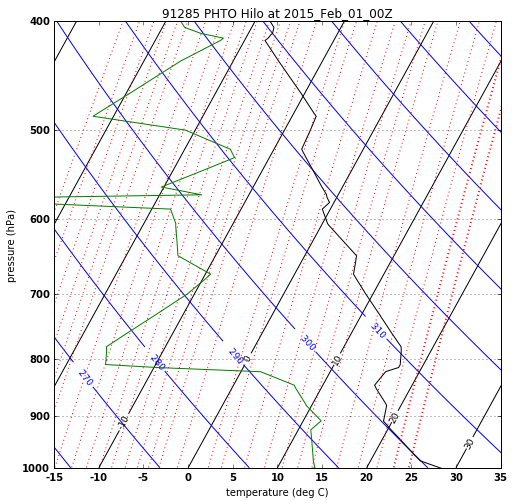

In [177]:

#%config InlineBackend.close_figures=False
fig,ax =plt.subplots(1,1,figsize=(8,8))
ax,skew = makeSkewDry(ax)

filename='hilo.h5';
print('reading file: %s\n' %filename)

attributes={}
with h5py.File(filename,'r') as f:
    keys=f.attrs.keys()
    for key in keys:
        try:
            attributes[key]=f.attrs[key]
        except IOError:
            print('empty key: ',key)

separator= '\n' + '+'*30 + '\n'
sounding_dict={}
with pd.HDFStore(filename,'r') as store:
    times=store.keys()
    for the_time in times:
        sounding_dict[the_time]=store[the_time]
sounding=sounding_dict[times[3]]
title_string=attributes['header']
index=title_string.find(' Observations at')
location=title_string[:index]
title='{} at {}'.format(location,times[0][2:])
units=attributes['units'].split(';')
units_dict={}
for count,var in enumerate(sounding.columns):
    units_dict[var]=units[count]

# get upper limit to allow functions to work less in upper atmosphere where we aren't plotting
sample_sounding=sounding[sounding['pres']>=400]

parameter_list=zip(sample_sounding['temp'],sample_sounding['dwpt'],sample_sounding['pres'])

xcoord_T=[]
xcoord_Td=[]

for a_temp,a_dew,a_pres in parameter_list:
    xcoord_T.append(convertTempToSkew(a_temp,a_pres,skew))
    xcoord_Td.append(convertTempToSkew(a_dew,a_pres,skew))
ax.plot(xcoord_T,sample_sounding['pres'],color='k',label='temp')
ax.plot(xcoord_Td,sample_sounding['pres'],color='g',label='dew')

mixing_ratios = [0.5,0.6,0.7,0.8,0.9,1.,1.2,1.4,1.6,1.8,2.,2.25,2.50,2.75,3.,3.5,4.5,
                 5.,6.,7.,8.,9.,10.,12.,14.,16.,18.,20]
                 
for r in mixing_ratios:
    r=r/1000.
    isohumes = [find_isohume_temp(press, r) for press in sample_sounding['pres']]
    parameter_list=zip(isohumes, sample_sounding['pres'])
    xcoord_r = []
    for a_isohume, a_pres in parameter_list:
        xcoord_r.append(convertTempToSkew(a_isohume,a_pres,skew))
    ax.plot(xcoord_r,sample_sounding['pres'],color='r',label='r',linestyle=':')


[line.set(linewidth=2) for line in ax.lines[-2:]]
ax.set(title=title)
ax.set(ylim=[1000,400])
fig.canvas.draw()
